# Qiskit Aer: Pulse simulation of a backend model

This notebook shows how to use the Aer pulse simulator using a model generated from a backend. In particular, we run a Rabi experiment to find a $\pi$-pulse amplitude on a model of the Armonk one qubit backend, generated from the `FakeArmonk` mock backend.

## Table of contents

1) [Imports](#imports)


2) [Construct model from backend](#model)


3) [Run Rabi experiments and fit $\pi$-pulse amplitude](#rabi)

## 1. Imports <a name='imports'></a>

Import general libraries:

In [1]:
import numpy as np

Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:

In [2]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

Import `PulseSimulator` and `PulseSystemModel` for pulse simulation, as well as the mock Armonk backend:

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

## 2. Construct model from backend <a name='model'></a>

This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** Hamiltonian parameters reported in the backends change over time. To stabilize this tutorial relative to these changes, after instantiating `FakeArmonk`, we manually override the Hamiltonian reported in the backend configuration to static values. 

Instantiate mock backend:

In [4]:
armonk_backend = FakeArmonk()

Manually override Hamiltonian parameters:

In [5]:
freq_est = 4.97e9
drive_est = 6.35e7
armonk_backend.defaults().qubit_freq_est = [freq_est]
armonk_backend.configuration().hamiltonian['h_str']= ['wq0*0.5*(I0-Z0)', 'omegad0*X0||D0']
armonk_backend.configuration().hamiltonian['vars'] = {'wq0': 2 * np.pi * freq_est, 'omegad0': drive_est}
armonk_backend.configuration().hamiltonian['qub'] = {'0': 2}
armonk_backend.configuration().dt = 2.2222222222222221e-10

Generate model from backend:

In [19]:
armonk_sim = PulseSimulator.from_backend(armonk_backend)
armonk_sim.set_options(dynamic_reprate_enabled=True, default_rep_delay=[0.])

In [20]:
armonk_sim.configuration().to_dict()

{'backend_name': 'pulse_simulator(fake_armonk)',
 'backend_version': '1.1.1',
 'n_qubits': 1,
 'basis_gates': ['id', 'u1', 'u2', 'u3'],
 'gates': [{'name': 'id',
   'parameters': [],
   'qasm_def': 'gate id q { U(0,0,0) q; }',
   'coupling_map': [[0]]},
  {'name': 'u1',
   'parameters': ['lambda'],
   'qasm_def': 'gate u1(lambda) q { U(0,0,lambda) q; }',
   'coupling_map': [[0]]},
  {'name': 'u2',
   'parameters': ['phi', 'lambda'],
   'qasm_def': 'gate u2(phi,lambda) q { U(pi/2,phi,lambda) q; }',
   'coupling_map': [[0]]},
  {'name': 'u3',
   'parameters': ['theta', 'phi', 'lambda'],
   'qasm_def': 'gate u3(theta,phi,lambda) q { U(theta,phi,lambda) q; }',
   'coupling_map': [[0]]}],
 'local': False,
 'simulator': True,
 'conditional': False,
 'open_pulse': True,
 'memory': True,
 'max_shots': 8192,
 'coupling_map': None,
 'max_experiments': 75,
 'sample_name': 'SPARROW',
 'n_registers': 1,
 'credits_required': True,
 'online_date': '2019-10-16T04:00:00+00:00',
 'description': 'A Pulse

## 3. Run Rabi experiments and fit $\pi$-pulse amplitude <a name='rabi'></a>

Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

First, construct Rabi experiment schedules:

In [8]:
# qubit list
qubits = [0]

# drive amplitudes to use
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

# list of drive channels
drive_channels = [DriveChannel(0)]

# construct the schedules
rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps, 
                                       qubits=qubits, 
                                       pulse_width=drive_duration, 
                                       pulse_sigma=drive_sigma,
                                       drives=drive_channels, 
                                       inst_map=armonk_sim.defaults().instruction_schedule_map, 
                                       meas_map=armonk_sim.configuration().meas_map)

Assemble the `qobj` for job submission. When assembling pulse schedules to be used with the pulse simulator, pass the `PulseSimulator` as the backend.

In [21]:
rabi_qobj = assemble(rabi_schedules, 
                     backend=armonk_sim,
                     meas_level=1, 
                     meas_return='avg',
                     shots=512)

/Users/dpuzzuoli/Documents/projects/qiskit-terra/qiskit/compiler/assemble.py:293: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Run the simulation:

In [10]:
sim_result = armonk_sim.run(rabi_qobj).result()

Generate the Rabi oscillation plot and find the $\pi$-pulse amplitude:

Pi Amp: 0.346866


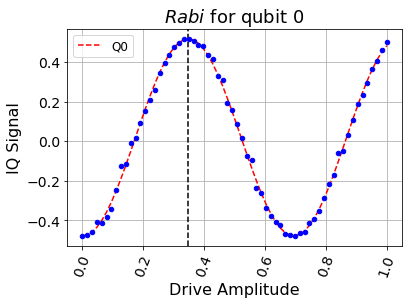

In [11]:
rabi_fit = RabiFitter(sim_result, xdata, qubits, fit_p0 = [1.5, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_fit.pi_amplitude(0)

# plot
rabi_fit.plot(0)
print('Pi Amp: %f'%pi_amp)

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright